In [29]:
using Test 
using Profile
using ProfileView
using Revise
using DataStructures
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1186


In [2]:
include("src/FEFMM.jl")

Main.FEFMM

In [3]:
κ2 = ones(101,101,101)
dx = [0.1,0.1,0.1]
x0 = CartesianIndex(1,1,1)
τa3d = zeros(101,101,101)
τaxis = 0:0.1:10
for k in 1:101
    for j in 1:101
        for i in 1:101
            τa3d[i,j,k] = sqrt(τaxis[i]^2+τaxis[j]^2+τaxis[k]^2)
        end
    end
end

In [4]:
R = Float64
N = 3

3

In [5]:
ordering = Array{Int}(undef, length(κ2))
cs = FEFMM.cartstrides(κ2)
inds = CartesianIndices(κ2)
I1 = first(inds)
Iend = last(inds)
τ0 = ones(R, size(κ2))
FEFMM.mul_analytic!(τ0, dx, x0)
∇τ0 = Array{typeof(τ0)}(undef, 0)
for i in 1:length(size(τ0))
    ∇τ0i = ones(R, size(κ2))
    FEFMM.mul_grad_analytic!(∇τ0i, dx, x0, i)
    push!(∇τ0, ∇τ0i)
end
τ1 = Inf.*ones(R, size(κ2))
τ1[x0] = κ2[x0]
tags = ones(UInt8,size(κ2))
tags[x0] = 0x2
α = Array{R}(undef,length(size(τ1)))
β = similar(α)
LI = LinearIndices(τ1)
xn = Array{typeof(I1)}(undef, N*2)

6-element Array{CartesianIndex{3},1}:
 CartesianIndex(4, 5, 6)   
 CartesianIndex(8, 11, 12) 
 CartesianIndex(15, 18, 26)
 CartesianIndex(27, 28, 30)
 CartesianIndex(32, 33, 35)
 CartesianIndex(55, 56, 0) 

In [6]:
front = BinaryMinHeap{FEFMM.Node{R}}()
push!(front, FEFMM.Node(inds[x0], τ1[x0]*τ0[x0])) 

BinaryHeap{Main.FEFMM.Node{Float64},DataStructures.LessThan}(DataStructures.LessThan(), Main.FEFMM.Node{Float64}[Node{Float64}(CartesianIndex(1, 1, 1), 0.0)])

In [7]:
front

BinaryHeap{Main.FEFMM.Node{Float64},DataStructures.LessThan}(DataStructures.LessThan(), Main.FEFMM.Node{Float64}[Node{Float64}(CartesianIndex(1, 1, 1), 0.0)])

In [8]:
ocount = 1
x = pop!(front).ind
ordering[ocount] = LI[x]
ocount += 1
tags[x] = 0x3
FEFMM.set_neighbours!(xn, x, tags, cs, I1, Iend)

In [9]:
y = xn[2]

CartesianIndex(2, 1, 1)

In [10]:
@time FEFMM.solve_node(τ1, α, β, τ0, ∇τ0, tags, κ2, CartesianIndex(2,1,1), dx, cs, I1, Iend)

  0.086942 seconds (194.50 k allocations: 9.145 MiB)


1.0

In [34]:
@btime FEFMM.solve_node(τ1, α, β, τ0, ∇τ0, tags, κ2, CartesianIndex(2,1,1), dx, cs, I1, Iend)

  212.274 ns (10 allocations: 160 bytes)


1.0

In [78]:
@btime 1+1

  0.034 ns (0 allocations: 0 bytes)


2

In [74]:
@btime x+s

  19.623 ns (1 allocation: 32 bytes)


CartesianIndex(10440504, 1, 1)

In [54]:
@btime FEFMM.cilt(y, Iend)

  15.907 ns (0 allocations: 0 bytes)


true

In [20]:
Profile.init()

(1000000, 0.001)

In [21]:
Profile.clear()

In [22]:
@profile for i = 1:1000000
    FEFMM.solve_node(τ1, α, β, τ0, ∇τ0, tags, κ2, CartesianIndex(2,1,1), dx, cs, I1, Iend)
end

In [23]:
Profile.print()

193 ./task.jl:259; (::getfield(IJulia, Symbol("##15#1...
 193 ...GIANC/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  193 ./essentials.jl:741; invokelatest
   193 ./essentials.jl:742; #invokelatest#1
    193 ...rc/execute_request.jl:67; execute_request(::ZMQ.Socket, ::I...
     193 ...c/SoftGlobalScope.jl:218; softscope_include_string(::Modu...
      193 ./boot.jl:328; eval
       193 ./In[22]:1; top-level scope
        193 ...file/src/Profile.jl:25; macro expansion
         193 ./In[22]:2; macro expansion
          9   ...toredeikonalfmm.jl:14; solve_node(::Array{Float64,3}...
           8 ./iterators.jl:138; iterate
            8 ./iterators.jl:139; iterate
             8 ./array.jl:705; iterate
              8 ./array.jl:705; iterate
               8 ./array.jl:729; getindex
          5   ...toredeikonalfmm.jl:15; solve_node(::Array{Float64,3}...
           5 ...c/fefmmutilities.jl:48; check1fwd
            3 ./multidimensional.jl:458; getindex
             3 ./array.jl:730; getindex

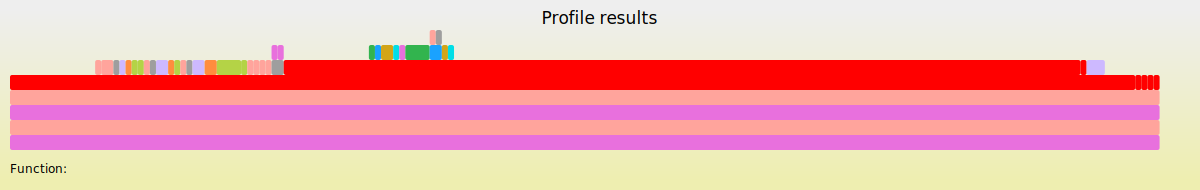

In [15]:
ProfileView.view()

In [81]:
@code_llvm FEFMM.solve_node(τ1, α, β, τ0, ∇τ0, tags, κ2, CartesianIndex(2,1,1), dx, cs, I1, Iend)


;  @ /Users/jackbmuir/Documents/Code/FEFMM/src/factoredeikonalfmm.jl:14 within `solve_node'
define double @julia_solve_node_13438(%jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), { [3 x i64] } addrspace(11)* nocapture nonnull readonly dereferenceable(24), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), { [3 x i64] } addrspace(11)* nocapture nonnull readonly dereferenceable(24), { [3 x i64] } addrspace(11)* nocapture nonnull readonly dereferenceable(24)) {
top:
  %12 = alloca %jl_value_t addrspace(10)*, i32

In [39]:
    function const_k2(h)
        #Define Medium
        a = -0.4
        s0 = 2.0
        #Set up grid
        X = 0.0:h:8.0
        Y = 0.0:h:4.0
        sx = 4.0
        sy = 0.0 
        sxi = findfirst(x->x==sx, X)
        syi = findfirst(y->y==sy, Y)
        x0 = CartesianIndex(syi, sxi)
        dist2 = ((X.-sx)').^2 .+ ((Y.-sy)).^2
        depth = 0.0*(X.-sx)'.+(Y.-sy)
        k2 = s0^2 .+ 2*a*depth
        Sb2 = s0^2 .+ a*depth
        sig2 = 2*dist2./(Sb2.+sqrt.(Sb2.^2 .- a*a*dist2))
        t_exact = Sb2.*sqrt.(sig2) .- a*a*sqrt.(sig2).^3 ./ 6
        (x0, k2, t_exact)
    end

    function const_v2(h)
        #Define Medium
        a = 1.0
        s0 = 2.0
        #Set up grid
        X = 0.0:h:8.0
        Y = 0.0:h:4.0
        sx = 4.0
        sy = 0.0 
        sxi = findfirst(x->x==sx, X)
        syi = findfirst(y->y==sy, Y)
        x0 = CartesianIndex(syi, sxi)
        dist2 = ((X.-sx)').^2 .+ ((Y.-sy)).^2
        depth = 0.0*(X.-sx)'.+(Y.-sy)
        k = 1 ./ (1/s0 .+ a*depth)

        t_exact = @. 1/a*acosh(1+1/2*s0*a*a*k*dist2)
        (x0, k.^2, t_exact)
    end

const_v2 (generic function with 1 method)

In [42]:
h = 1/40
(x0, k2, t_exact) = const_k2(h)
(t_pred, ordering) = FEFMM.fefmm(k2, [h,h], x0)
Profile.clear()  # in case we have any previous profiling data
h = 1/320
(x0, k2, t_exact) = const_k2(h)
@time FEFMM.fefmm(k2, [h,h], x0)
@profile FEFMM.fefmm(k2, [h,h], x0)

 11.516943 seconds (177.79 M allocations: 4.681 GiB, 4.67% gc time)


([7.94694 7.94082 … 7.94082 7.94694; 7.94567 7.93955 … 7.93955 7.94567; … ; 8.35076 8.34796 … 8.34796 8.35076; 8.35076 8.34797 … 8.34797 8.35076], [1639681, 1639682, 1640962, 1638400, 1640963, 1638401, 1639683, 1642243, 1637119, 1638402  …  3280637, 1277, 1278, 3280638, 1279, 3280639, 1280, 3280640, 1281, 3280641])

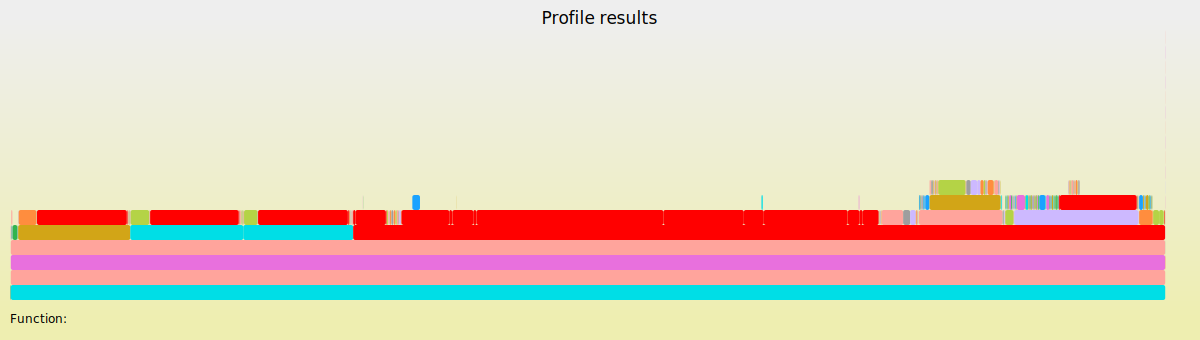

In [41]:
ProfileView.view()